In [78]:
import numpy as np
from pylab import *

%matplotlib notebook

In [554]:
# trace is a list of (width, offset), one for each channel
nchan = 8
trace1 = [(0, 0) for w in range(nchan)]
trace2 = [(0, 1) for w in range(nchan)]
trace3 = [(1,1) for w in range(nchan)]
trace4 = [(1,w % 2) for w in range(nchan)]
traces = [trace1, trace2, trace3, trace4]

In [555]:
trace4

[(1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1)]

In [556]:
def trace2mask(trace):
    nc = len(trace)
    widths = [t[0] for t in trace]
    offsets = [t[1] for t in trace]
    last_w = widths[-1]
    last_off = offsets[-1]
    total_offset = sum(offsets)
    nt = last_w + total_offset
    mask = np.zeros((nc,nt), dtype=bool)
    coffset = nt-1 # cumulative offset
    for ichan, (width, offset) in enumerate(trace):
        print(ichan, width, offset, coffset)
        mask[ichan, coffset:coffset+width+1] = True
        coffset -= offset
        
        
    return mask
        

In [557]:
trace1

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]

In [558]:
trace2

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

<IPython.core.display.Javascript object>


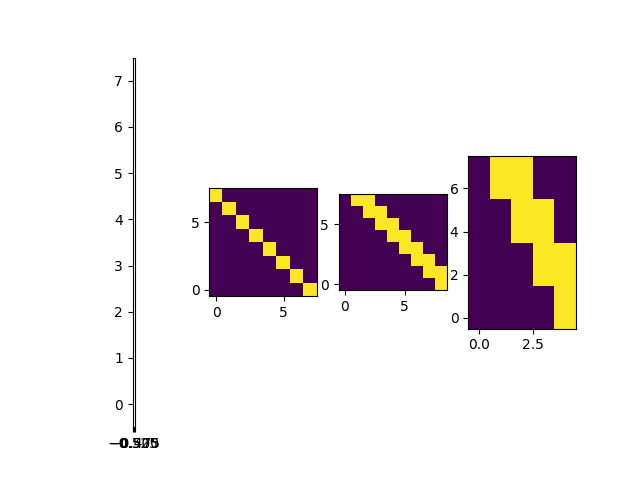

0 0 0 -1
1 0 0 -1
2 0 0 -1
3 0 0 -1
4 0 0 -1
5 0 0 -1
6 0 0 -1
7 0 0 -1
0 0 1 7
1 0 1 6
2 0 1 5
3 0 1 4
4 0 1 3
5 0 1 2
6 0 1 1
7 0 1 0
0 1 1 8
1 1 1 7
2 1 1 6
3 1 1 5
4 1 1 4
5 1 1 3
6 1 1 2
7 1 1 1
0 1 0 4
1 1 1 4
2 1 0 3
3 1 1 3
4 1 0 2
5 1 1 2
6 1 0 1
7 1 1 1


/var/folders/46/9g9nrj1x70d5nyxrqm1z6yb4009_fc/T/ipykernel_21373/4078769406.py:3: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  myax.imshow(trace2mask(t), origin='lower')


In [559]:
fig, ax = subplots(1,len(traces))
for myax, t in zip(ax.flatten(), traces):
    myax.imshow(trace2mask(t), origin='lower')


In [633]:
from collections import namedtuple
Product = namedtuple('Product', ['pid_upper','pid_lower','offset', 'desc'])
EndProduct = namedtuple('EndProduct', ['width','desc'])


class FdmtDescriptor:
    def __init__(self, nchan, ichan):
        self._products = [] # list containing Products
        self.nchan = nchan
        self.ichan = ichan
        assert self.nchan == 1 or self.nchan % 2 == 0
        
        if nchan == 1:
            self.upper = None
            self.lower = None
        else:
            self.upper = FdmtDescriptor(nchan // 2, 2*ichan+1)
            self.lower = FdmtDescriptor(nchan // 2, 2*ichan)
        
    @property
    def ndm(self):
        return len(self._products)
    
    @property
    def nprod(self):
        return self.ndm
    
    @property
    def total_products(self):
        '''
        Returns total number of products in hierarchy
        '''
        if self.nchan == 1:
            return self.nprod
        else:
            return self.upper.total_products + self.lower.total_products + self.nprod
        
    def descriptor_tree(self, tree=None, level=0):
        '''
        Returns a list. Each element contains another list. That list contains all descriptors for that iteration
        '''
        if tree is None:
            tree = []
        if self.ichan == 0:
            tree.append([])
            
        tree[level].append(self)
        if self.nchan != 1:
            self.lower.descriptor_tree(tree, level+1)
            self.upper.descriptor_tree(tree, level+1)
        
        return tree              
    
    def get_all_pids(self, all_pids):
        list_idx = int(np.log2(self.nchan))
        if self.nchan == 1:
            all_pids[list_idx].extend(self._products)
        else:
            all_pids[list_idx].extend(self._products)
            self.upper.get_all_pids(all_pids)
            self.lower.get_all_pids(all_pids)
    
    def get_trace_pid(self, trace) -> int:
        '''
        Returns the product ID for the given trace
        trace:list of nchan values. Each value is tuple(width, offset)'
        '''
        assert len(trace) == self.nchan, f'Unexpedcted trace length in {self}. Was {len(trace)} expected {self.nchan}'
        
        n2 = self.nchan // 2
        if self.nchan == 1:
            width, offset = trace[0]
            prod = EndProduct(width, self)
        else:
            pid_lower = self.lower.get_trace_pid(trace[:n2])
            pid_upper = self.upper.get_trace_pid(trace[n2:])
            assert n2 - 1 >= 0
            mid_width, mid_offset = trace[n2-1] # offset and width of the lower of the 2 middle channels
            prod = Product(pid_upper, pid_lower, mid_offset, self)
        
        added = False
        if prod not in self._products:
            self._products.append(prod)
            added = True
            
        pid = self._products.index(prod)
        #print(f'{self} of trace {trace}={prod}=PID{pid} added?={added}')
        
        return pid
        
     
    def __str__(self):
        s = f'Nchan={self.nchan} chan={self.ichan} ndm={self.ndm}'
        return s
    
    __repr__ = __str__
    
    
d = FdmtDescriptor(nchan,0)
d

Nchan=8 chan=0 ndm=0

In [634]:
mtree = d.descriptor_tree()
print('tree depth', len(mtree))
for itree, t in enumerate(mtree):
    print('tree level', itree, 'nnodes=', len(t), t)

tree depth 4
tree level 0 nnodes= 1 [Nchan=8 chan=0 ndm=0]
tree level 1 nnodes= 2 [Nchan=4 chan=0 ndm=0, Nchan=4 chan=1 ndm=0]
tree level 2 nnodes= 4 [Nchan=2 chan=0 ndm=0, Nchan=2 chan=1 ndm=0, Nchan=2 chan=2 ndm=0, Nchan=2 chan=3 ndm=0]
tree level 3 nnodes= 8 [Nchan=1 chan=0 ndm=0, Nchan=1 chan=1 ndm=0, Nchan=1 chan=2 ndm=0, Nchan=1 chan=3 ndm=0, Nchan=1 chan=4 ndm=0, Nchan=1 chan=5 ndm=0, Nchan=1 chan=6 ndm=0, Nchan=1 chan=7 ndm=0]


In [635]:
d.nchan

8

In [636]:
d.lower.nchan

4

In [637]:
d.lower.lower.nchan

2

In [638]:
d.upper.upper.upper.ichan

7

In [639]:
len(trace1)

8

In [640]:
d.get_trace_pid(trace1)

0

In [641]:
d.get_trace_pid(trace1)

0

In [642]:
d._products

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=1)]

In [643]:
d.total_products

15

In [644]:
d.get_trace_pid(trace2)

1

In [645]:
d.total_products

22

In [646]:
trace4

[(1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1)]

In [647]:
d.get_trace_pid(trace4)

2

In [648]:
d._products

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=8 chan=0 ndm=3),
 Product(pid_upper=1, pid_lower=1, offset=1, desc=Nchan=8 chan=0 ndm=3),
 Product(pid_upper=2, pid_lower=2, offset=1, desc=Nchan=8 chan=0 ndm=3)]

In [649]:
d.total_products

37

In [650]:
trace4m = trace4[:]
trace4m[-1] = (2,1)
trace4m

[(1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (2, 1)]

In [652]:
all_pids = [[] for i in range(int(np.log2(nchan))+1)]
d.get_all_pids(all_pids)
all_pids[1]

[Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=3 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=3 ndm=3),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=3 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=2 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=2 ndm=3),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=2 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=1 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=1 ndm=3),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=1 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=0, desc=Nchan=2 chan=0 ndm=3),
 Product(pid_upper=0, pid_lower=0, offset=1, desc=Nchan=2 chan=0 ndm=3),
 Product(pid_upper=1, pid_lower=1, offset=0, desc=Nchan=2 chan=0 ndm=3)]

In [653]:
d.total_products

37

In [654]:
d.descriptor_tree()

[[Nchan=8 chan=0 ndm=3],
 [Nchan=4 chan=0 ndm=3, Nchan=4 chan=1 ndm=3],
 [Nchan=2 chan=0 ndm=3,
  Nchan=2 chan=1 ndm=3,
  Nchan=2 chan=2 ndm=3,
  Nchan=2 chan=3 ndm=3],
 [Nchan=1 chan=0 ndm=2,
  Nchan=1 chan=1 ndm=2,
  Nchan=1 chan=2 ndm=2,
  Nchan=1 chan=3 ndm=2,
  Nchan=1 chan=4 ndm=2,
  Nchan=1 chan=5 ndm=2,
  Nchan=1 chan=6 ndm=2,
  Nchan=1 chan=7 ndm=2]]

In [656]:
def fdmt_iteration(iterno, input_buffer, output_buffer, fdmt_tables):

    for output_channel_index in fdmt_tables.channels(iterno):
        for odm, id1, id2, offset, inchan1, inchan2 in fdmt_tables.dmlist(iterno, output_channel_index):
            output_buffer[odm, output_channel_index, :] = input_buffer[id1, inchan1, :] \
                                                        + input_buffer[id2, inchan2, offset:]
                
                
def fdmt_function(input_buffer, output_buffer, fdmt_tables):
    buffers = [np.zeros(fdmt_tables.output_buffer(i)) for i in range(fdmt_tables.niter)]
    
    buffers[0] = input_buffer # allocate the input
    
    for iterno in fdmt_tables:
        fdmt_iteration(iterno, buffers[i], buffers[i+1], fdmt_tables)
        
        
    return buffers[-1]

